# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/SeaFlow_SizeDist_regrid-15-5.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

In [2]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

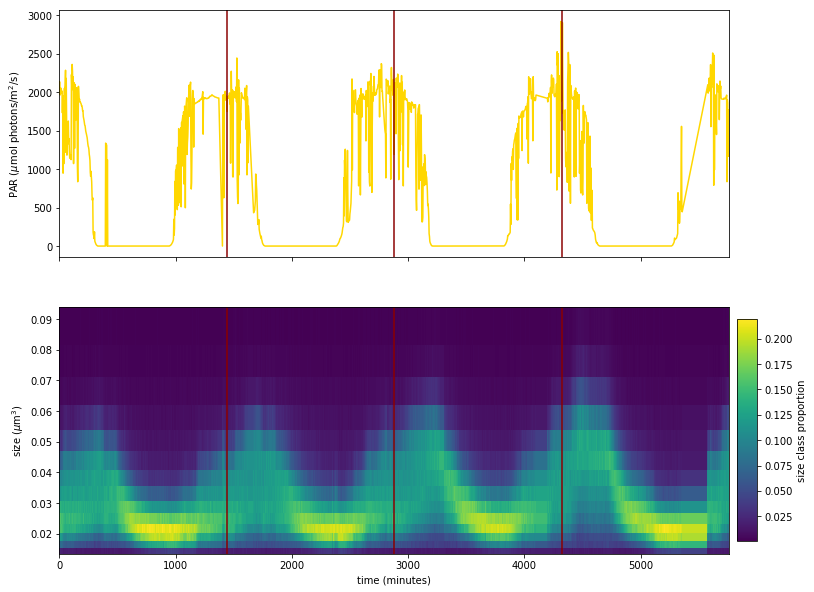

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

for i in range(1440,data_seaflow['time'][-1],1440):
    for ax in axs:
        ax.axvline(i, color='darkred')
    
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [4]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 4
stride_t_obs = 20

# remove very first observations
ind_obs = data['t_obs'] > 3
data['t_obs'] = data['t_obs'][ind_obs]
data['obs'] = data['obs'][:,ind_obs]

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

In [5]:
import pystan

model = pystan.StanModel(file='stancode/multilevel_sigmoidaldelta_normparam_trackgrowth.stan', model_name='multilevel_sigmoidaldelta', obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL multilevel_sigmoidaldelta NOW.


In [6]:
mcmc = model.sampling(data=data, iter=2000)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'mod_obspos' not in x))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: multilevel_sigmoidaldelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max_mu           6.64    0.03   1.35   4.26   5.67    6.6   7.53   9.36   2315    1.0
delta_max_sigma        0.69    0.02   0.75   0.02    0.2   0.47   0.93    2.7   2301    1.0
delta_max_raw[1]        0.4    0.02   0.94  -1.48  -0.25   0.42   1.03   2.18   2933    1.0
delta_max_raw[2]       0.04    0.01    0.9  -1.76  -0.55   0.05   0.63   1.81   3823    1.0
delta_max_raw[3]       0.05    0.02   0.93  -1.75  -0.57   0.03   0.67    1.9   3341    1.0
delta_max_raw[4]       0.05    0.02   0.91  -1.74  -0.56   0.06   0.68   1.79   3290    1.0
gamma_max_mu           4.84  9.9e-3    0.5   3.91   4.53   4.81   5.12   5.91   2577    1.0
gamma_max_sigma        0.59    0.01   0.52   0.02   0.22   0.47   0.81   1.93   1778    1.0
g

## Plot the results

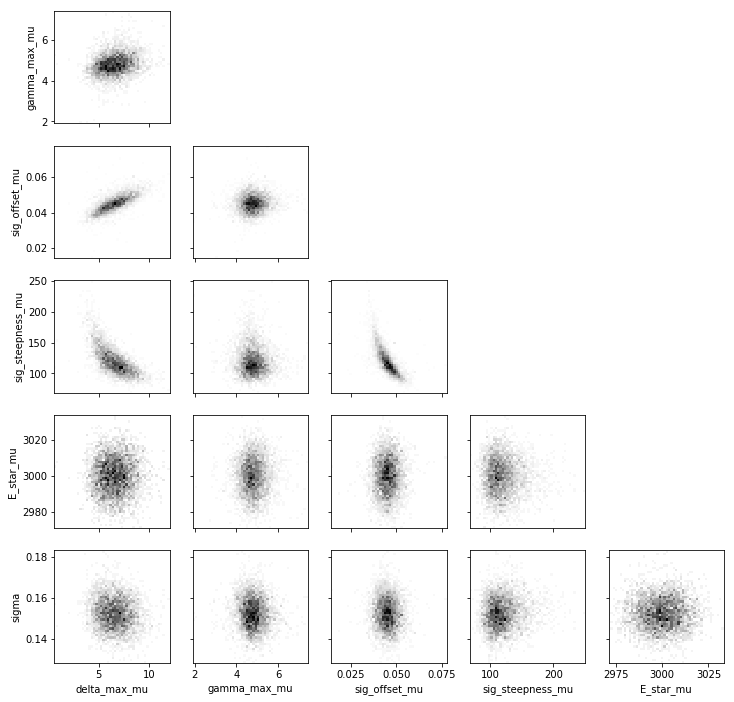

In [7]:
paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and '[' not in v and not v.endswith('_sigma')]
num_params = len(paramnames)

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames[icol]
        yname = paramnames[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)

In [ ]:
num_days = mcmc['delta_max'].shape[1]

# plotinfo contains information about the prior distribution of the parameters 
# used for plotting. If these are changed in the code above, change them here as well.
plotinfo = {
    'delta_max_mu':{'priordist':'normal', 'priorparams':(3.5, 2.0)},
    'sig_offset_mu':{'priordist':'uniform', 'priorparams':(v[0], v[-1])},
    'sig_steepness_mu':{'priordist':'lognormal', 'priorparams':(5.0, 1.0)},
    'gamma_max_mu':{'priordist':'uniform', 'priorparams':(0.0, 1440.0/data['dt']), 'xlim':(-0.1,10.1)},
    'E_star_mu':{'priordist':'normal', 'priorparams':(3000.0, 10.0)},
}

import scipy.stats as stats

ncols = 2
nrows = int(np.ceil(len(plotinfo)/ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3*nrows), gridspec_kw={'hspace':0.3})
for ax in axs.flat:
    ax.set_visible(False)
for ax,name in zip(axs.flat, plotinfo):
    ax.set_visible(True)
    ax.hist(mcmc[name], bins=20, density=True, label='posterior $\mu$', color='black')
    if name.endswith('_mu'):
        basename = name.replace('_mu','')
        for iday in range(num_days):
            name_day = '{}[{}]'.format(basename,iday+1)
            ax.hist(mcmc[name_day], bins=20, density=True, label='posterior (day {})'.format(iday+1), alpha=0.3)
    xlim = ax.get_xlim()
    if 'priordist' in plotinfo[name]:
        if plotinfo[name]['priordist'] == 'normal':
            p = plotinfo[name]['priorparams']
            x_min = min(p[0]-2*p[1], xlim[0])
            x_max = max(p[0]+2*p[1], xlim[1])
            x = np.linspace(x_min, x_max, 100)
            ax.plot(x, stats.norm.pdf(x, loc=p[0], scale=p[1]), label='prior $\mu$')
        elif plotinfo[name]['priordist'] == 'uniform':
            p = plotinfo[name]['priorparams']
            y = 1.0/(p[1]-p[0])
            ax.plot([p[0],p[0],p[1],p[1]], [0,y,y,0], label='prior $\mu$')
        elif plotinfo[name]['priordist'] == 'lognormal':
            p = plotinfo[name]['priorparams']
            x_min = max(0.0, xlim[0]-0.25*(xlim[1]-xlim[0]))
            x_max = xlim[1]+0.25*(xlim[1]-xlim[0])
            x = np.linspace(x_min, x_max, 100)
            ax.plot(x, stats.lognorm.pdf(x, s=p[1], scale=np.exp(p[0])), label='prior $\mu$')
    if 'xlim' in plotinfo[name]:
        ax.set_xlim(plotinfo[name]['xlim'])
    ax.set(title=name)
axs.flat[0].legend()
None

In [ ]:
ncols = 2
nrows = int(np.ceil(len(plotinfo)/ncols))

def plot_ksd(ax, samples, **kwargs):
    ksd = stats.gaussian_kde(samples)
    x_min = np.min(samples)
    x_max = np.max(samples)
    x = np.linspace(x_min, x_max, 200)
    ax.plot(x, ksd(x), **kwargs)
    
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4*nrows), gridspec_kw={'hspace':0.3})
for ax in axs.flat:
    ax.set_visible(False)
for ax,name in zip(axs.flat, plotinfo):
    ax.set_visible(True)
    plot_ksd(ax, mcmc[name], label='posterior $\mu$', lw=2, color='black')
    
    if name.endswith('_mu'):
        basename = name.replace('_mu','')
        for iday in range(num_days):
            name_day = '{}[{}]'.format(basename,iday+1)
            #ax.hist(mcmc[name_day], bins=20, density=True, label='posterior (day {})'.format(iday+1), alpha=0.3)
            plot_ksd(ax, mcmc[name_day], label='posterior (day {})'.format(iday+1), alpha=0.5)
    xlim = ax.get_xlim()
    if 'priordist' in plotinfo[name]:
        if plotinfo[name]['priordist'] == 'normal':
            p = plotinfo[name]['priorparams']
            x_min = min(p[0]-2*p[1], xlim[0])
            x_max = max(p[0]+2*p[1], xlim[1])
            x = np.linspace(x_min, x_max, 100)
            ax.plot(x, stats.norm.pdf(x, loc=p[0], scale=p[1]), lw=2, label='prior $\mu$')
        elif plotinfo[name]['priordist'] == 'uniform':
            p = plotinfo[name]['priorparams']
            y = 1.0/(p[1]-p[0])
            ax.plot([p[0],p[0],p[1],p[1]], [0,y,y,0], lw=2, label='prior $\mu$')
        elif plotinfo[name]['priordist'] == 'lognormal':
            p = plotinfo[name]['priorparams']
            x_min = max(0.0, xlim[0]-0.25*(xlim[1]-xlim[0]))
            x_max = xlim[1]+0.25*(xlim[1]-xlim[0])
            x = np.linspace(x_min, x_max, 100)
            ax.plot(x, stats.lognorm.pdf(x, s=p[1], scale=np.exp(p[0])), lw=2, label='prior $\mu$')
    if 'xlim' in plotinfo[name]:
        ax.set_xlim(plotinfo[name]['xlim'])
    ax.set(title=name)
axs.flat[0].legend()
None